In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import import_ipynb
from helpers import train_and_validate, count_parameters, plot_loss_comparison, plot_test_predictions, compare_mse_loss
import time
import matplotlib.pyplot as plt

importing Jupyter notebook from helpers.ipynb


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
window_size = 48
batch_size = 100
input_size = 1
hidden_size = 128
num_classes = 1
learning_rate = 0.001
epochs = 200
criterion = nn.MSELoss()

In [4]:
def root_mean_squared_error(actual, predicted):
    actual = torch.tensor(actual, dtype=torch.float32)
    predicted = torch.tensor(predicted, dtype=torch.float32)
    
    if actual.shape != predicted.shape:
        raise ValueError("Tensors must have the same shape.")
    
    mse = torch.mean((actual - predicted)**2)
    
    return (mse.item() ** 0.5)

In [5]:
df = pd.read_csv("./data/clean_data.csv")
df = df[:-24]
df.shape

(15955, 5)

In [6]:
df = df[["Date", "P (kW)"]]
train_df = df.iloc[:-48]
test = df.iloc[-48:]

In [7]:
def prepare_dataframe(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'P (kW)(t-{i})'] = df['P (kW)'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

In [8]:
new_df = prepare_dataframe(train_df, window_size)
new_df = new_df.to_numpy()
new_df

array([[  0.        ,   0.        ,   0.        , ...,  14.75265   ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 127.16308333,
         14.75265   ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 302.4557    ,
        127.16308333,  14.75265   ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [9]:
X = new_df[:, 1:]
y = new_df[:, 0]

In [10]:
X.shape, y.shape

((15859, 48), (15859,))

In [11]:
split_index = int(len(X) * 0.9)

In [12]:
X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14273, 48), (1586, 48), (14273,), (1586,))

In [13]:
X_train = X_train.reshape((-1, window_size, 1))
X_val = X_val.reshape((-1, window_size, 1))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14273, 48, 1), (1586, 48, 1), (14273, 1), (1586, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([14273, 48, 1]),
 torch.Size([1586, 48, 1]),
 torch.Size([14273, 1]),
 torch.Size([1586, 1]))

In [15]:
class SolarData(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [16]:
train = SolarData(X_train, y_train)
val = SolarData(X_val, y_val)

In [17]:
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val, batch_size = batch_size, shuffle = False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([100, 48, 1]) torch.Size([100, 1])


## RNN

In [19]:
class RNNNet(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.rnn_layer = nn.RNN(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, hidden = self.rnn_layer(x)
        out = self.fc(out[:, -1, :])
        return out

In [20]:
rnnnet = RNNNet(input_size, hidden_size, num_classes).to(device)
rnnnet_optimizer = torch.optim.Adam(rnnnet.parameters(), lr = learning_rate)

In [21]:
total_rnnnet_parameters = count_parameters(rnnnet)

In [22]:
rnnnet_train_loss_array = []
rnnnet_val_loss_array = []

In [23]:
rnnnet_start_time = time.time()
train_and_validate(epochs, device, rnnnet, train_loader, val_loader, criterion, rnnnet_optimizer, rnnnet_train_loss_array, rnnnet_val_loss_array)
rnnnet_end_time = time.time()
rnnnet_total_training_time = rnnnet_end_time - rnnnet_start_time
rnnnet_avg_training_time_per_epoch = rnnnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 83716.00295017482 | Validation Loss: 25374.13702392578
Epoch no.: 2 | Training Loss: 78091.56651551573 | Validation Loss: 23073.891021728516
Epoch no.: 3 | Training Loss: 72991.00986123252 | Validation Loss: 21042.427215576172
Epoch no.: 4 | Training Loss: 68325.95410839161 | Validation Loss: 19267.073333740234
Epoch no.: 5 | Training Loss: 63994.14720826049 | Validation Loss: 17663.369537353516
Epoch no.: 6 | Training Loss: 60059.5877267264 | Validation Loss: 16273.938400268555
Epoch no.: 7 | Training Loss: 56457.77931053322 | Validation Loss: 15110.625503540039
Epoch no.: 8 | Training Loss: 53167.51368553322 | Validation Loss: 14092.171417236328
Epoch no.: 9 | Training Loss: 50207.01274311626 | Validation Loss: 13176.128509521484
Epoch no.: 10 | Training Loss: 47367.438920454544 | Validation Loss: 12381.109954833984
Epoch no.: 11 | Training Loss: 44806.47058020105 | Validation Loss: 11783.401351928711
Epoch no.: 12 | Training Loss: 42461.49825174825 | Va

In [24]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     RNN: {total_rnnnet_parameters}")
print()
print(f"Total Training Time:     RNN: {rnnnet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     RNN: {rnnnet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     RNN: 16897

Total Training Time:     RNN: 111.27s

Average Training Time Per Epoch:     RNN: 0.56s
------------------------------------------------------------


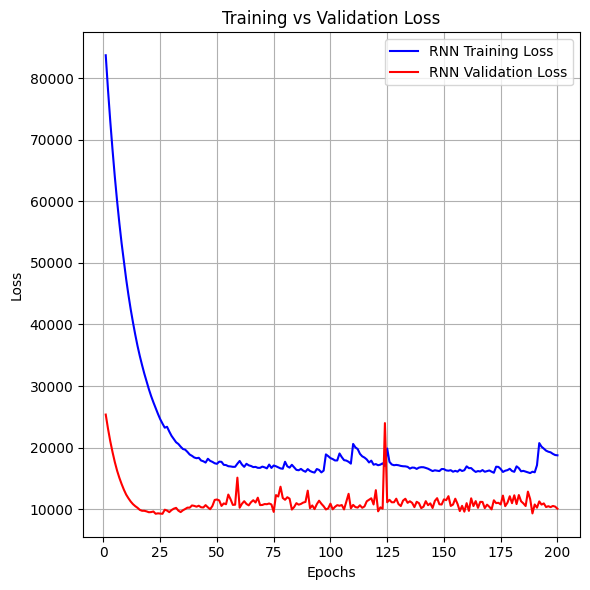

In [25]:
plot_loss_comparison(epochs, rnnnet_train_loss_array, rnnnet_val_loss_array, "RNN Training Loss", "RNN Validation Loss", "Training vs Validation Loss")

In [28]:
rnnnet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(24):
    # Make the prediction
    with torch.no_grad():
        pred_test = rnnnet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_6536\3326979704.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


ValueError: x and y must have same first dimension, but have shapes (48,) and (24,)

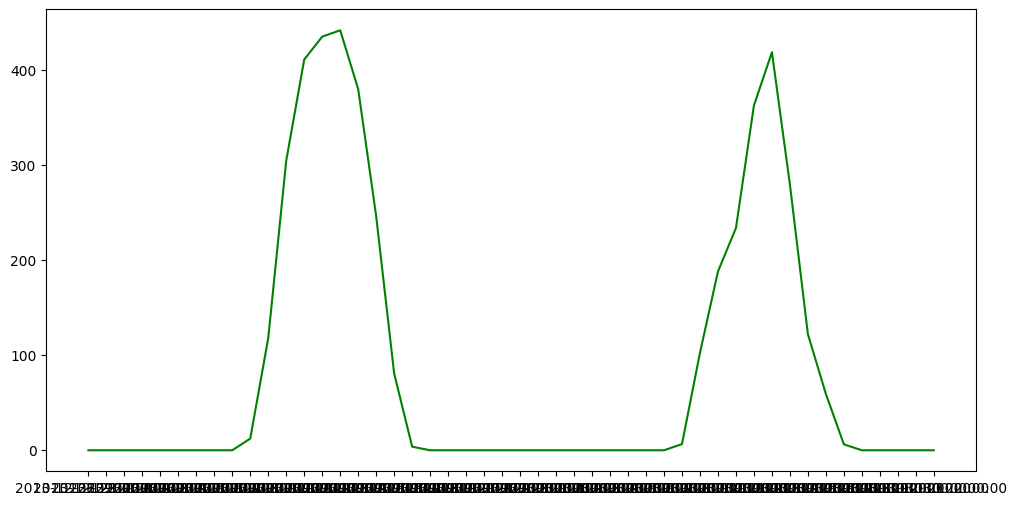

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs RNN Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
mse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
print(f"Mean Squared Error: {mse}")

## LSTM

In [ ]:
class LSTMNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x_, (h_t, c_t) = self.lstm(x)
        out = self.fc(x_[:, -1, :])
        return out

In [ ]:
lstmnet = LSTMNet(input_size, hidden_size, num_classes).to(device)
lstmnet_optimizer = torch.optim.Adam(lstmnet.parameters(), lr = learning_rate)

In [ ]:
total_lstmnet_parameters = count_parameters(lstmnet)

In [ ]:
lstmnet_train_loss_array = []
lstmnet_val_loss_array = []

In [ ]:
lstmnet_start_time = time.time()
train_and_validate(epochs, device, lstmnet, train_loader, val_loader, criterion, lstmnet_optimizer, lstmnet_train_loss_array, lstmnet_val_loss_array)
lstmnet_end_time = time.time()
lstmnet_total_training_time = lstmnet_end_time - lstmnet_start_time
lstmnet_avg_training_time_per_epoch = lstmnet_total_training_time / epochs

In [ ]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     RNN: {total_lstmnet_parameters}")
print()
print(f"Total Training Time:     RNN: {lstmnet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     RNN: {lstmnet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")

In [ ]:
plot_loss_comparison(epochs, lstmnet_train_loss_array, lstmnet_val_loss_array, "LSTM Training Loss", "LSTM Validation Loss", "Training vs Validation Loss")

In [ ]:
lstmnet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(24):
    # Make the prediction
    with torch.no_grad():
        pred_test = lstmnet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## GRU 

In [ ]:
class GRUNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.lstm = nn.GRU(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x_, (h_t, c_t) = self.lstm(x)
        out = self.fc(x_[:, -1, :])
        return out

In [ ]:
grunet = LSTMNet(input_size, hidden_size, num_classes).to(device)
grunet_optimizer = torch.optim.Adam(grunet.parameters(), lr = learning_rate)

In [ ]:
total_grunet_parameters = count_parameters(grunet)

In [ ]:
grunet_train_loss_array = []
grunet_val_loss_array = []

In [ ]:
grunet_start_time = time.time()
train_and_validate(epochs, device, grunet, train_loader, val_loader, criterion, grunet_optimizer, grunet_train_loss_array, grunet_val_loss_array)
grunet_end_time = time.time()
grunet_total_training_time = grunet_end_time - grunet_start_time
grunet_avg_training_time_per_epoch = grunet_total_training_time / epochs

In [ ]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     RNN: {total_grunet_parameters}")
print()
print(f"Total Training Time:     RNN: {grunet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     RNN: {grunet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")

In [ ]:
plot_loss_comparison(epochs, grunet_train_loss_array, grunet_val_loss_array, "GRU Training Loss", "GRU Validation Loss", "Training vs Validation Loss")

In [ ]:
grunet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(24):
    # Make the prediction
    with torch.no_grad():
        pred_test = grunet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs GRU Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()